# Predicting EV registration in UK by charging point locations


In a chicken-and-egg thought experiment, it seems reasonable that buyers of new electric vehicles may want to be assured they have a well located place to charge their vehicle available while out and about before they make their purchase.

I would like to explore this idea through data, by seeing if we can use data on the location of publicly available electric vehicle (EV) charging points across the UK to predict EV registration.

The two datasets I am using for this assessment can be found below:<br>
[UK Gov: Public EV Charging Points](https://www.gov.uk/guidance/find-and-use-data-on-public-electric-vehicle-chargepoints)
<br>
[UK Gov: VEH0142 - EV Registration 2009-2022](https://www.gov.uk/government/statistical-data-sets/vehicle-licensing-statistics-data-tables)

To begin this task we will need to clean the datasets and merge the most relevant parts for our assessment into a single dataframe.


### Importing the Electric Vehicle registration data

In [1]:
import numpy as np
import pandas as pd
import re
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
evs = pd.read_csv('EVs_from_veh0142.csv')
ev = pd.DataFrame(evs)
ev.head(5)

,Units,BodyType,Fuel,Keepership [note 3],ONS Sort [note 6],ONS Code [note 6],ONS Geography [note 6],2022 Q3,2022 Q2,2022 Q1,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
0,Number,Buses and coaches,Battery electric,Company,1,K02000001,United Kingdom,"1,808","1,707","1,572",...,[x],[x],[x],[x],[x],[x],[x],[x],[x],[x]
1,Number,Buses and coaches,Battery electric,Company,2,K03000001,Great Britain,"1,702","1,602","1,513",...,54,58,57,59,58,49,45,41,40,38
2,Number,Buses and coaches,Battery electric,Company,3,E92000001,England,"1,343","1,249","1,194",...,51,55,54,57,55,46,43,39,38,36
3,Number,Buses and coaches,Battery electric,Company,4,E12000001,North East,21,12,12,...,7,12,12,13,14,7,5,[c],[c],[c]
4,Number,Buses and coaches,Battery electric,Company,5,E06000047,County Durham,[c],[c],[c],...,0,0,[c],[c],[c],[c],[c],0,0,0


In [3]:
print('Values in "Units" column = \n' + str(ev['Units'].value_counts()))
print('\nValues in "BodyType" column = \n' + str(ev['BodyType'].value_counts()))
print('\nValues in "Fuel" column = \n' + str(ev['Fuel'].value_counts()))
print('\nValues in "Keepership" column = \n' + str(ev['Keepership [note 3]'].value_counts()))

Values in "Units" column = 
Number    33059
Name: Units, dtype: int64

Values in "BodyType" column = 
Total                   6702
Cars                    6697
Light goods vehicles    6024
Other vehicles          5112
Motorcycles             3424
Buses and coaches       2556
Heavy goods vehicles    2544
Name: BodyType, dtype: int64

Values in "Fuel" column = 
Total                               9196
Battery electric                    9177
Plug-in hybrid electric (petrol)    6112
Range extended electric             5146
Plug-in hybrid electric (diesel)    3428
Name: Fuel, dtype: int64

Values in "Keepership" column = 
Total      11366
Private    10890
Company    10803
Name: Keepership [note 3], dtype: int64


#### So we have the following columns:
- **Units:** only in 'number', keeps things easy.
- **BodyType:** the type of vehicle, e.g. car, bus, motorcycle, etc.
- **Fuel**: the type of electric vehicle fuel type.
- **Keepership**: whether owned by a private individual or a company.
- **ONS Sort:** Office of National Statistics sorting field.
- **ONS Code:** Office of National Statistics code for the local authority that the vehicle is registered to
- **ONS Geography**: Office of National Statistics local authority name in plain English. Denotes where the vehicle is registered.
- **Columns 7-58**: the number of EVs registered each quarter, between Q4 2009 and Q3 2022.


Every column seems to come with a 'Total' row of its own, as well as a count by their unique breakdowns.


#### Some notes from the dataset:
- Quarters follow the calendar year, so:<br>Q1 = end of March<br>Q2 = end of June<br>Q3 = end of September<br>Q4 = end of December
- Keepership refers to the registered keeper of the vehicle, which might not be the owner.
- Vehicles are allocated to a local authority according to the postcode of the registered keeper. This is the keeper's address for privately owned vehicles or the company's registered address for company owned vehicles. The address does not necessarily reflect where the vehicle is located. This is especially true for large fleets kept by companies involved with vehicle management, leasing or rentals. Significant changes in the number of vehicles from year to year can often occur when these companies change their registered address.
- The exact geographical location of a vehicle registration cannot always be allocated due to the postcode being incomplete or invalid. <i>We might see this in the data, where the overarching local authority appears to have more vehicles registered than the underlying regions within it would account for</i>

## Importing the Charging Points Data

In [4]:
relevant_cols = ['reference', 'latitude', 'longitude', 'town', 'county'
                 , 'postcode', 'deviceOwnerName', 'chargeDeviceStatus'
                , 'dateCreated', 'lastUpdated', 'paymentRequired', 'subscriptionRequired'
                , 'parkingFeesFlag', 'accessRestrictionFlag', 'physicalRestrictionFlag'
                , 'onStreetFlag', 'access24Hours', 'connector1ChargeMethod'
                , 'connector2ChargeMethod']
cps = pd.read_csv('national-charge-point-registry.csv', lineterminator='\n', usecols=relevant_cols)
cps = pd.DataFrame(cps)
cps.head(5)

,reference,latitude,longitude,town,county,postcode,deviceOwnerName,chargeDeviceStatus,dateCreated,lastUpdated,paymentRequired,subscriptionRequired,parkingFeesFlag,accessRestrictionFlag,physicalRestrictionFlag,onStreetFlag,access24Hours,connector1ChargeMethod,connector2ChargeMethod
0,SC22,54.592703,-5.933430,Belfast,County Antrim,BT2 7JQ,ecars ESB,In service,2012-04-12 10:17:49,2021-07-06 11:16:43,0,1,0,0,0.0,0.0,0.0,Three Phase AC,Three Phase AC
1,SC23,54.604646,-5.931866,Belfast,County Antrim,BT1 2JD,ecars ESB,In service,2012-04-12 14:00:01,2021-07-06 11:24:08,1,1,0,0,0.0,1.0,0.0,Three Phase AC,Three Phase AC
2,SC33,54.594109,-5.924292,Belfast,County Antrim,BT2 8JN,ecars ESB,Out of service,2012-04-12 14:10:27,2021-07-06 11:24:26,1,1,0,0,0.0,0.0,0.0,Three Phase AC,Three Phase AC
3,SC03,54.593365,-5.935574,Belfast,County Antrim,BT12 5ED,ecars ESB,In service,2012-04-12 14:16:09,2021-07-06 11:24:44,1,1,0,0,0.0,0.0,0.0,Three Phase AC,Three Phase AC
4,SC19,54.594342,-5.928256,Belfast,County Antrim,BT2 8GB,ecars ESB,In service,2012-04-12 14:17:57,2021-07-06 11:25:17,1,1,0,0,0.0,1.0,0.0,Three Phase AC,Three Phase AC


The original dataset had a number of columns empty or irrelevant to this study, so I have just imported the relevant ones.

We have:

- <b>Reference</b>: Unique identifier of the CP
- <b>Latitude</b>: coordinates
- <b>Longitude</b>: coordinates
- <b>Town</b>: Location
- <b>County</b>: Location
- <b>Postcode</b>: CP postcode location
- <b>deviceOwnerName</b>: the owner of the CP
- <b>chargeDeviceStatus</b>: whether CP is in or out of service
- <b>dateCreated</b>: date the CP was registered with Gov
- <b>lastUpdated</b>: last update of the register about the CP
- <b>paymentRequired</b>: 0 = false, 1 = true, does the CP require payment for use
- <b>subscriptionRequired</b>: 0 = false, 1 = true, does the CP require a subscription for use
- <b>parkingFeesFlag</b>: 0 = false, 1 = true, does the CP have a parking fee associated
- <b>accessRestrictionFlag</b>: 0 = false, 1 = true, is access to the CP restricted (e.g. by an access code)
- <b>physicalRestrictionFlag</b>: 0 = false, 1 = true, is access to the CP physically restricted
- <b>onStreetFlag</b>: 0 = false, 1 = true, is the CP on a public street
- <b>access24Hours</b>: 0 = false, 1 = true, is the CP available 24 hours a day
- <b>connector1ChargeMethod</b>: charge method of first connector
- <b>connector2ChargeMethod</b>: charge method of second connector


## Data Cleaning - EVs table

Tasks:
- Remove [note X] from column names
- Change columns to lowercase and snake case as appropriate
- Check for null values and remove
- Convert numeric columns to integers

In [5]:
#Cleaning column names 

cols_list = ev.columns.to_list()
new_cols = []

for item in cols_list:
    #removes spaces
    item = item.replace(' ','')
    #snake_case instead of camel case
    item = re.sub(r'(?<=[a-zA-Z0-9]{3})(?=[A-Z])','_', item)
    #lowercase
    item = item.lower()
    #remove [noteX]
    item = re.sub(r'\[[^\]]*\]', '', item)
    new_cols.append(item)

ev.columns = new_cols


#Columns 7-58, all rows
ev.iloc[:,7:] = ev.iloc[:,7:].replace('[x]', np.NaN)
ev.iloc[:,7:] = ev.iloc[:,7:].replace('[c]', np.NaN)
ev.iloc[:,7:] = ev.iloc[:,7:].replace(',','', regex=True)
ev.iloc[:,7:] = ev.iloc[:,7:].astype(float)

ev

/var/folders/jb/5csh6qnx4y7brg28_7d39qyw0000gq/T/ipykernel_7525/3611493383.py:24: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ev.iloc[:,7:] = ev.iloc[:,7:].astype(float)


,units,body_type,fuel,keepership,ons_sort,ons_code,ons_geography,2022_q3,2022_q2,2022_q1,...,2012_q1,2011_q4,2011_q3,2011_q2,2011_q1,2010_q4,2010_q3,2010_q2,2010_q1,2009_q4
0,Number,Buses and coaches,Battery electric,Company,1,K02000001,United Kingdom,1808.0,1707.0,1572.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Number,Buses and coaches,Battery electric,Company,2,K03000001,Great Britain,1702.0,1602.0,1513.0,...,54.0,58.0,57.0,59.0,58.0,49.0,45.0,41.0,40.0,38.0
2,Number,Buses and coaches,Battery electric,Company,3,E92000001,England,1343.0,1249.0,1194.0,...,51.0,55.0,54.0,57.0,55.0,46.0,43.0,39.0,38.0,36.0
3,Number,Buses and coaches,Battery electric,Company,4,E12000001,North East,21.0,12.0,12.0,...,7.0,12.0,12.0,13.0,14.0,7.0,5.0,NaN,NaN,NaN
4,Number,Buses and coaches,Battery electric,Company,5,E06000047,County Durham,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33054,Number,Total,Total,Total,460,N09000010,"Newry, Mourne and Down",693.0,612.0,537.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33055,Number,Total,Total,Total,461,[z],Local Authority unknown within Northern Ire...,761.0,657.0,597.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33056,Number,Total,Total,Total,462,[z],"Vehicle under disposal, previously GB",15301.0,11780.0,9500.0,...,326.0,206.0,200.0,304.0,218.0,151.0,142.0,192.0,133.0,131.0
33057,Number,Total,Total,Total,463,[z],"Vehicle under disposal, previously NI",191.0,117.0,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning the CP dataset
- Change from camel case to snake case
- Change date columns to datetime format

In [6]:
#streamlining the snake case loop into a function

def snake_case(dataframe):
    
    cols_list = dataframe.columns.to_list()
    new_cols = [] 

    for item in cols_list:
        #snake_case instead of camel case
        item = re.sub(r'(?<=[a-zA-Z0-9]{3})(?=[A-Z])','_', item)
        #lowercase
        item = item.lower()
        new_cols.append(item)

    dataframe.columns = new_cols
    return dataframe

cps = snake_case(cps)

In [7]:
#Changing to timestamps
cps['date_created'] = pd.to_datetime(cps['date_created'], errors='coerce')
cps['last_updated'] = pd.to_datetime(cps['last_updated'], errors='coerce')

## Merging the two datasets

We want to be able to see whether the location of charging points (and other factors related to charging points) can be used to predict electric vehicle registration.

Ideally, I would have a single dataset to do this with the following information:
- Year
- Location (name)
- Location (latitude, longitude)
- Number of charging points, broken down by whether they are paid/free, accessible, on street, 24-hours, type of charge
- Number of electric vehicles, broken down by keepership, fuel type, body type


One way to do this would be by merging on the location strings. In the EV dataframe this is the 'ons_geography' column, while in the CP dataframe it could be a mix of the 'town' or 'county' dataframes. If there are strings that match, I'll keep the data. If not, we will drop it.

This should be fine -- in the EV dataframe there is a lot of doubled-up data as there are rows for both local areas, counties, and at the national level. We want to make these predictions at a fairly local level (counties at largest).

Lets take a look at the Town and County columns in the CP database to get a feel for which would be most appropriate for a merge. I'll do this by extracting the strings from the EV 'ons_geography' column and seeing which of the CP columns has the best matches.

In [8]:
ev_locales = list(ev['ons_geography'].unique())
cp_towns = list(cps['town'].unique())
cp_counties = list(cps['county'].unique())

In [9]:
#Some of the lists above need cleaning, this should help

def string_cleaner(old_list):
    new_list = []
    
    for item in old_list:
        item = str(item)
        #lowercases
        item = item.lower()
        #removes any leading spaces
        item = re.sub("^\s+","", item)
        new_list.append(item)
        
    return new_list

In [10]:
#Cleaning the lists
ev_locales = string_cleaner(ev_locales)
cp_towns = string_cleaner(cp_towns)
cp_counties = string_cleaner(cp_counties)

In [11]:
#Use set intersections to check for string matches
town_match = set(ev_locales).intersection(cp_towns)
county_match = set(ev_locales).intersection(cp_counties)

In [12]:
print('Match % between cp_towns and ev_locales: ' + str(round(100*len(town_match)/len(cp_towns),2)))
print('Match % between cp_counties and ev_locales: ' + str(round(100*len(county_match)/len(cp_counties),2)))

Match % between cp_towns and ev_locales: 12.06
Match % between cp_counties and ev_locales: 42.74


Looks like the county_match list has a better percentage of matches with ev_locales, let's look more closely

In [13]:
print(county_match)

{'milton keynes', 'east riding of yorkshire', 'northumberland', 'surrey', 'exeter', 'somerset', 'liverpool', 'falkirk', 'highland', 'isle of wight', 'north east lincolnshire', 'midlothian', 'devon', 'north lanarkshire', 'united kingdom', 'west midlands', 'walsall', 'warrington', 'dudley', 'sunderland', 'cumbria', 'essex', 'middlesbrough', 'powys', 'dorset', 'redcar and cleveland', 'warwickshire', 'london', 'neath port talbot', 'norfolk', 'na h-eileanan siar', 'swindon', 'dartford', 'city of edinburgh', 'staffordshire', 'lancashire', 'vale of glamorgan', 'cambridgeshire', 'conwy', 'wolverhampton', 'east dunbartonshire', 'north lincolnshire', 'reading', 'winchester', 'lincolnshire', 'doncaster', 'oxfordshire', 'darlington', 'denbighshire', 'preston', 'plymouth', 'cheshire west and chester', 'derbyshire', 'east sussex', 'nottinghamshire', 'carmarthenshire', 'dumfries and galloway', 'north somerset', 'bridgend', 'waverley', 'peterborough', 'aberdeen city', 'cardiff', 'south tyneside', 'wes

I can see a couple of London's in there - City of London and London separately. Also, there is a mix of counties, towns and countries. For example we have 'Scotland', 'Blackpool' and 'Shropshire'. I know in Scotland some cities are counties in themselves, e.g. the City of Edinburgh, but Blackpool is not (it's in Lancashire) and so this does create a confusing mix.

Does the town_match data fare better?

In [14]:
print(town_match)

{'milton keynes', 'cotswold', 'selby', 'northumberland', 'high peak', 'exeter', 'boston', 'surrey', 'havering', 'brent', 'worcester', 'croydon', 'calderdale', 'somerset', 'liverpool', 'falkirk', 'kingston upon thames', 'isle of wight', 'devon', 'huntingdonshire', 'barnet', 'colchester', 'dudley', 'walsall', 'warrington', 'west midlands', 'sunderland', 'fareham', 'cumbria', 'essex', 'middlesbrough', 'powys', 'dorset', 'kirklees', 'tower hamlets', 'redcar and cleveland', 'bromsgrove', 'london', 'warwickshire', 'stratford-on-avon', 'tamworth', 'derby', 'solihull', 'cheltenham', 'dartford', 'swindon', 'norfolk', 'carlisle', 'bromley', 'oldham', 'chorley', 'sheffield', 'waltham forest', 'sutton', 'staffordshire', 'merton', 'runnymede', 'stockport', 'lancashire', 'scarborough', 'camden', 'chichester', 'harrow', 'east lindsey', 'tewkesbury', 'cambridgeshire', 'conwy', 'st. helens', 'wolverhampton', 'chelmsford', 'harrogate', 'redbridge', 'east hampshire', 'reading', 'north lincolnshire', 'oxf

A similar mix is in this list too, with both counties and towns visible. We might need a new tool instead of this matching.

Can the ONS geography codes in the EV data help?

According to [the Wikipedia page on ONS coding](https://en.wikipedia.org/wiki/ONS_coding_system), we can use the prefixes in the ons_code column of the EV table to find just a specific type of region, e.g. county, electoral division, etc. 

The table on that page advises us that not every UK nation will have a prefix to use for each category of locale. 

Originally I wanted to look at all UK nations and so I searched for locale type that existed in England, Wales, Scotland and Northern Ireland. I chose the Ward/Electoral Division categories, but below I found that the prefixes I need for this don't exist in the ev dataset.

Instead, I've decided to focus just on London Boroughs, which have a prefix of E09 and a number of results.

Now that I have a cohesive locale type to look for, I will need to:
- Filter my EV dataframe for just the regions with codes that match our prefixes
- Do as above with the set intersection against the CP dataframe, but with just the filtered ons_geography strings

In [15]:
#filtering ev to check for English Wards -- prefix E05.
prefix_filter  = ev['ons_code'].str.startswith('E05')

In [16]:
prefix_filter.value_counts()
#There are no English ward level items in the database. Will move on to another type of locale.

False    33059
Name: ons_code, dtype: int64

In [17]:
#London Boroughs
london = ev[(ev['ons_code'].str.contains('E09'))]
london

,units,body_type,fuel,keepership,ons_sort,ons_code,ons_geography,2022_q3,2022_q2,2022_q1,...,2012_q1,2011_q4,2011_q3,2011_q2,2011_q1,2010_q4,2010_q3,2010_q2,2010_q1,2009_q4
215,Number,Buses and coaches,Battery electric,Company,216,E09000007,Camden,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
216,Number,Buses and coaches,Battery electric,Company,217,E09000001,City of London,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
217,Number,Buses and coaches,Battery electric,Company,218,E09000012,Hackney,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
218,Number,Buses and coaches,Battery electric,Company,219,E09000013,Hammersmith and Fulham,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
219,Number,Buses and coaches,Battery electric,Company,220,E09000014,Haringey,34.0,34.0,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32863,Number,Total,Total,Total,269,E09000024,Merton,3052.0,2835.0,2582.0,...,22.0,23.0,25.0,26.0,28.0,28.0,29.0,31.0,26.0,26.0
32864,Number,Total,Total,Total,270,E09000026,Redbridge,3167.0,2956.0,2747.0,...,NaN,5.0,5.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
32865,Number,Total,Total,Total,271,E09000027,Richmond upon Thames,4232.0,3916.0,3539.0,...,36.0,38.0,38.0,41.0,42.0,42.0,43.0,40.0,37.0,37.0
32866,Number,Total,Total,Total,272,E09000029,Sutton,2041.0,1857.0,1699.0,...,11.0,11.0,9.0,10.0,10.0,10.0,10.0,13.0,13.0,10.0


In [18]:
#I'll remove the rows that are Totals later - let's just see how much overlap there is between
#the CP dataframe and the EV dataframe for London Boroughs first.

london_locales = list(london['ons_geography'].unique())
london_locales = string_cleaner(london_locales)

london_town_match = set(london_locales).intersection(cp_towns)
london_county_match = set(london_locales).intersection(cp_counties)

In [19]:
print('Match % between cp_towns and london_locales: ' + str(round(100*len(london_town_match)/len(cp_towns),2)))
print('Match % between cp_counties and london_locales: ' + str(round(100*len(london_county_match)/len(cp_counties),2)))

Match % between cp_towns and london_locales: 1.51
Match % between cp_counties and london_locales: 0.82


Much smaller percentages but then again we are looking at a much smaller part of the UK geographically than before, so this seems reasonable. Nevertheless, the towns column in the CP dataframe seems to do a better job of matching, so we'll use that one.

In [20]:
print('Size of county match list = ' + str(len(london_county_match)))
print('Size of town match list = ' + str(len(london_town_match)))
print('Items in both town and county match list for London = ' + str(set(london_county_match).intersection(london_town_match)))

Size of county match list = 3
Size of town match list = 30
Items in both town and county match list for London = {'southwark', 'lambeth', 'city of london'}


The locales in the london_county_match list are also in the london_town_match list, so we're not going to be missing data from those locations regardless.

## Pre-processing the EV data
We're now ready to start making some predictive models about the relationship between EV registration and CPs around London.

However, our EV dataset is not quite up to scratch for this. It contains lots of rows with 'Total' amounts, and the data is not easily summed because of all the different ways of breaking it down (ownership type, fuel, etc).

So we'll clean it up a bit first and then discuss.

In [21]:
#removing rows that are Totals
london_clean =  london[~(london['body_type'] == 'Total') 
                       & ~(london['fuel'] == 'Total') 
                       & ~(london['keepership'] == 'Total')]

In [22]:
london_clean.tail(5)

,units,body_type,fuel,keepership,ons_sort,ons_code,ons_geography,2022_q3,2022_q2,2022_q1,...,2012_q1,2011_q4,2011_q3,2011_q2,2011_q1,2010_q4,2010_q3,2010_q2,2010_q1,2009_q4
24467,Number,Other vehicles,Range extended electric,Private,244,E09000024,Merton,57.0,56.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24468,Number,Other vehicles,Range extended electric,Private,245,E09000026,Redbridge,120.0,110.0,109.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24469,Number,Other vehicles,Range extended electric,Private,246,E09000027,Richmond upon Thames,21.0,19.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24470,Number,Other vehicles,Range extended electric,Private,247,E09000029,Sutton,91.0,84.0,79.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24471,Number,Other vehicles,Range extended electric,Private,248,E09000031,Waltham Forest,105.0,98.0,86.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
#Sum all the quarterly data into annual data for ease.

#Need to melt the dataframe first

quarter_cols = london_clean.iloc[:0,7:]

ldn_melt = pd.melt(london_clean, id_vars =['ons_geography', 'ons_code', 'fuel', 'body_type', 'keepership']
                   , value_vars=quarter_cols
                   , var_name='quarter'
                   , value_name='total_vehicles')

#now adding a year column for ease of summing

quarts = ldn_melt['quarter'].str.replace(r'_', '-') #cleans up the formatting of the quarters column
ldn_melt['quarter'] = pd.PeriodIndex(quarts, freq='q').to_timestamp() #changes quarters to timestamps
ldn_melt['year'] = ldn_melt['quarter'].dt.year #extract year to new col
ldn_melt

,ons_geography,ons_code,fuel,body_type,keepership,quarter,total_vehicles,year
0,Camden,E09000007,Battery electric,Buses and coaches,Company,2022-07-01,NaN,2022
1,City of London,E09000001,Battery electric,Buses and coaches,Company,2022-07-01,0.0,2022
2,Hackney,E09000012,Battery electric,Buses and coaches,Company,2022-07-01,0.0,2022
3,Hammersmith and Fulham,E09000013,Battery electric,Buses and coaches,Company,2022-07-01,NaN,2022
4,Haringey,E09000014,Battery electric,Buses and coaches,Company,2022-07-01,34.0,2022
...,...,...,...,...,...,...,...,...
48043,Merton,E09000024,Range extended electric,Other vehicles,Private,2009-10-01,0.0,2009
48044,Redbridge,E09000026,Range extended electric,Other vehicles,Private,2009-10-01,0.0,2009
48045,Richmond upon Thames,E09000027,Range extended electric,Other vehicles,Private,2009-10-01,0.0,2009
48046,Sutton,E09000029,Range extended electric,Other vehicles,Private,2009-10-01,0.0,2009


In [24]:
#Groupby statement to sum annual data
total_ldn_evs = ldn_melt.groupby(['ons_geography', 'ons_code'])['total_vehicles'].sum()
total_ldn_evs = pd.DataFrame(total_ldn_evs).reset_index()
total_ldn_evs.head(5)

,ons_geography,ons_code,total_vehicles
0,Barking and Dagenham,E09000002,13952.0
1,Barnet,E09000003,75714.0
2,Bexley,E09000004,22341.0
3,Brent,E09000005,41301.0
4,Bromley,E09000006,40178.0


## Pre-processing the CP dataframe

I need to be able to count how many CPs are in a particular Borough. To do this I will:
- filter the CP dataframe for just London Borough located CPs
- groupby borough and other relevant columns

In [25]:
#We have our london_locales list of boroughs already, so just need to check for matches between that and the df.
#Need to clean the strings in the dataframe first as the list is all lowercase

cps['town'] = string_cleaner(cps['town'])

In [26]:
ldn_cp_towns = list(cps['town'].unique())
ldn_cp_towns = list(set(ldn_cp_towns).intersection(london_locales))
ldn_cp_towns

['redbridge',
 'havering',
 'brent',
 'croydon',
 'lambeth',
 'kingston upon thames',
 'hillingdon',
 'barking and dagenham',
 'barnet',
 'bexley',
 'wandsworth',
 'city of london',
 'tower hamlets',
 'southwark',
 'haringey',
 'hounslow',
 'islington',
 'hackney',
 'lewisham',
 'bromley',
 'ealing',
 'waltham forest',
 'newham',
 'sutton',
 'merton',
 'camden',
 'harrow',
 'greenwich',
 'westminster',
 'enfield']

In [27]:
#finding which boroughs are missing from the list
missing = [x for x in london_locales if x not in ldn_cp_towns]
missing

['hammersmith and fulham', 'kensington and chelsea', 'richmond upon thames']

In [28]:
#I'll add these missing boroughs in,
#but as individual towns, as the the CP dataframe has listed them as individual towns
missing_locales = ['hammersmith', 'fulham', 'kensington', 'chelsea', 'richmond']
ldn_cp_towns = ldn_cp_towns + missing_locales

In [29]:
#filtering the CP dataframe now by the borough list
ldn_cps = cps[cps['town'].str.contains('|'.join(ldn_cp_towns),regex=True)]

In [30]:
#Checking the borough list from the CP dataframe is correct
list(ldn_cps['town'].unique())

['west kensington',
 'sutton coldfield',
 'brentwood',
 'hounslow',
 'wandsworth',
 'south croydon',
 'croydon',
 'greenwich',
 'richmond',
 'newham',
 'coulby newham',
 'harrow',
 'bexleyheath',
 'hounslow ',
 'haringey',
 'enfield',
 'camden town',
 'camden',
 'brentford',
 'chelsea',
 'lambeth',
 'kingston upon thames',
 'bromley',
 'hillingdon',
 'sutton',
 'bexley',
 'ealing',
 'westminster',
 'hackney',
 'lewisham',
 'brent',
 'merton',
 'barnet',
 'havering',
 'redbridge',
 'islington',
 'waltham forest',
 'city of london',
 'hammersmith',
 'southwark',
 'south kensington',
 'haringey ',
 'islington ',
 'tower hamlets',
 'london borough of hammersmith ',
 'barking and dagenham',
 'long sutton',
 'bromley north',
 'fulham',
 'hammersmith.',
 'hammersmith ',
 'hammersmith & fulham',
 'sutton valence',
 'merton ',
 'bromley south',
 'south lambeth',
 'sutton bridge',
 'city of westminster']

I see some problems with this list:
- We have lots of 'sutton' matches - not all of them in London e.g. sutton coldfield
- We have double-ups of some areas, e.g. camden and camden town
- I see 3 different versions of Hammersmith due to spelling/punctuation

Need to tidy up

In [31]:
#First, create filter to remove the listings that are not boroughs
not_boroughs = ['sutton coldfield', 'coulby newham', 'bexleyheath', 'long sutton', 'bromley north'
              , 'sutton valence', 'bromley south', 'south lambeth', 'sutton bridge', 'brentwood']

filter_1 = ~ldn_cps['town'].isin(not_boroughs)

ldn_cps = ldn_cps[filter_1]

#Then to fix the doubled-up Hammersmiths into a single name

ldn_cps['town'].replace('hammersmith ','hammersmith and fulham', inplace=True)
ldn_cps['town'].replace('hammersmith.', 'hammersmith and fulham', inplace=True)
ldn_cps['town'].replace('hammersmith & fulham', 'hammersmith and fulham', inplace=True)
ldn_cps['town'].replace('hammersmith', 'hammersmith and fulham', inplace=True)

#Fixing doubled-up camden/camden town
ldn_cps['town'].replace('camden town', 'camden', inplace=True)

#Removing end-space from any that have it
ldn_cps['town'] = ldn_cps['town'].apply(lambda x: re.sub(r'\s+$', '', x))

In [32]:
#Checking list length. Should be 33 -- this is the number of London Boroughs and the length of the official list
#from the EV dataframe.
cp_towns = ldn_cps['town'].unique()
len_cp_towns = len(cp_towns)
print('Length of CP towns list = ' + str(len_cp_towns))
print('Length of London Locales list = ' + str(len(london_locales)))

Length of CP towns list = 40
Length of London Locales list = 33


Still some cleaning to do -- let's check what is missing.

In [33]:
missing = [x for x in cp_towns if x not in london_locales]
missing

['west kensington',
 'south croydon',
 'richmond',
 'brentford',
 'chelsea',
 'south kensington',
 'london borough of hammersmith',
 'fulham',
 'city of westminster']

Looks like a lot of names where we can just change them to the original, e.g. West Kensington can be Kensington, and also both Kensington and Chelsea. Richmond can change it's name to the official 'Richmond upon Thames', and so on. I'll do this final clean up below

In [34]:
ldn_cps['town'].replace('richmond', 'richmond upon thames', inplace=True)

ldn_cps['town'].replace('kensington', 'kensington and chelsea', inplace=True)
ldn_cps['town'].replace('west kensington', 'kensington and chelsea', inplace=True)
ldn_cps['town'].replace('south kensington', 'kensington and chelsea', inplace=True)
ldn_cps['town'].replace('chelsea', 'kensington and chelsea', inplace=True)

ldn_cps['town'].replace('fulham', 'hammersmith and fulham', inplace=True)

ldn_cps['town'].replace('city of westminster', 'westminster', inplace=True)

ldn_cps['town'].replace('brentford', 'hounslow', inplace=True)

ldn_cps['town'].replace('south croydon', 'croydon', inplace=True)

ldn_cps['town'].replace('london borough of hammersmith', 'hammersmith and fulham', inplace=True)

In [35]:
#Now to check if everything matches

cp_towns_2 = ldn_cps['town'].unique()
print('London Boroughs in the CP dataframe: ' + str(len(cp_towns_2)))

missing = [x for x in cp_towns_2 if x not in london_locales]
print('Total Boroughs missing between CP and EV dataframe: '+ str(len(missing)))

London Boroughs in the CP dataframe: 33
Total Boroughs missing between CP and EV dataframe: 0


Perfect! Our lists now match, meaning they can talk to one another about the same London Boroughs. There are 32 London Boroughs + the City of London ([reference](https://www.londoncouncils.gov.uk/who-runs-london/essential-guide-london-local-government#:~:text=Council%20structure,represented%20by%20three%20elected%20councillors.)), so our list is spot on.

Our two dataframes are now below:

In [36]:
ldn_cps.head(5)

,reference,latitude,longitude,town,county,postcode,device_owner_name,charge_device_status,date_created,last_updated,payment_required,subscription_required,parking_fees_flag,access_restriction_flag,physical_restriction_flag,onstreet_flag,access24_hours,connector1_charge_method,connector2_charge_method
89,PP-10010,51.493000,-0.202000,kensington and chelsea,Greater London,W14 8PB,POD Point,In service,2012-06-18 13:48:51,NaT,1,1,0,0,0.0,1.0,NaN,Single Phase AC,Single Phase AC
1344,PP-12204,51.475000,-0.366000,hounslow,Greater London,TW3 4DN,POD Point,In service,2013-09-24 05:09:37,2015-10-13 11:58:57,1,1,0,0,0.0,1.0,0.0,Single Phase AC,Single Phase AC
1403,PP-5112337,51.454495,-0.190534,wandsworth,Greater London,SW18 4AD,POD Point,In service,2013-09-24 05:09:46,NaT,1,1,0,0,0.0,1.0,NaN,Single Phase AC,Single Phase AC
1404,PP-5112338,51.454495,-0.190534,wandsworth,Greater London,SW18 4AD,POD Point,In service,2013-09-24 05:09:46,NaT,1,1,0,0,0.0,1.0,NaN,Single Phase AC,Single Phase AC
1405,PP-5112339,51.454495,-0.190534,wandsworth,Greater London,SW18 4AD,POD Point,In service,2013-09-24 05:09:46,NaT,1,1,0,0,0.0,1.0,NaN,Single Phase AC,Single Phase AC


In [37]:
#just making sure all the boroughs are lower case
ldn_melt['ons_geography'] = string_cleaner(ldn_melt['ons_geography'])
ldn_melt.head(5)

,ons_geography,ons_code,fuel,body_type,keepership,quarter,total_vehicles,year
0,camden,E09000007,Battery electric,Buses and coaches,Company,2022-07-01,NaN,2022
1,city of london,E09000001,Battery electric,Buses and coaches,Company,2022-07-01,0.0,2022
2,hackney,E09000012,Battery electric,Buses and coaches,Company,2022-07-01,0.0,2022
3,hammersmith and fulham,E09000013,Battery electric,Buses and coaches,Company,2022-07-01,NaN,2022
4,haringey,E09000014,Battery electric,Buses and coaches,Company,2022-07-01,34.0,2022


## SO WHAT NOW?

I want to understand whether the presence of charging points in a London Borough can predict the registration of electric vehicles.

We can see in the EV's dataframe that there are not just cars registered - we have buses too, for example. We also have business and personal ownership logged. For this study to avoid issues, we'll focus just on privately owned cars. This is because:
- buses and coaches (and other business vehicles) are likely to be housed in a business with access to their own private charging points
- businesses may register their EV's to their business address, and not actually where they are used.

<br><br>

As there are many variables involved in the charging points database (parking fees, payment required, etc), a good place to start looking might be with a correlation matrix.

To do this, I want to:

- Filter the EV database by privately owned cars only
- Group the number of electric vehicles by Borough. Because the database takes all registered vehicles by quarter, it is likely double-counting cars that continue to be registered quarter-to-quarter. That is, it's a register of all vehicles and not just newly registered ones. As a result we need to be careful not to simply sum them, but instead I will take a mean of the count of vehicles across most recent years.
- Count the number of charging points per Borough, broken down by the variables

In [81]:
#filtering for privately owned cars only
ldn_cars = ldn_melt[(ldn_melt['body_type'] == 'Cars') & (ldn_melt['keepership'] == 'Private')]

#Taking the mean number of privately owned cars by London Borough since 2019
ldn_cars_mean = ldn_cars[ldn_cars['year'] > 2019].groupby('ons_geography')['total_vehicles'].mean()

In [85]:
#Count the number of charging points in the CP dataframe by Borough
borough_cps = ldn_cps.groupby('town')['reference'].nunique().sort_values()

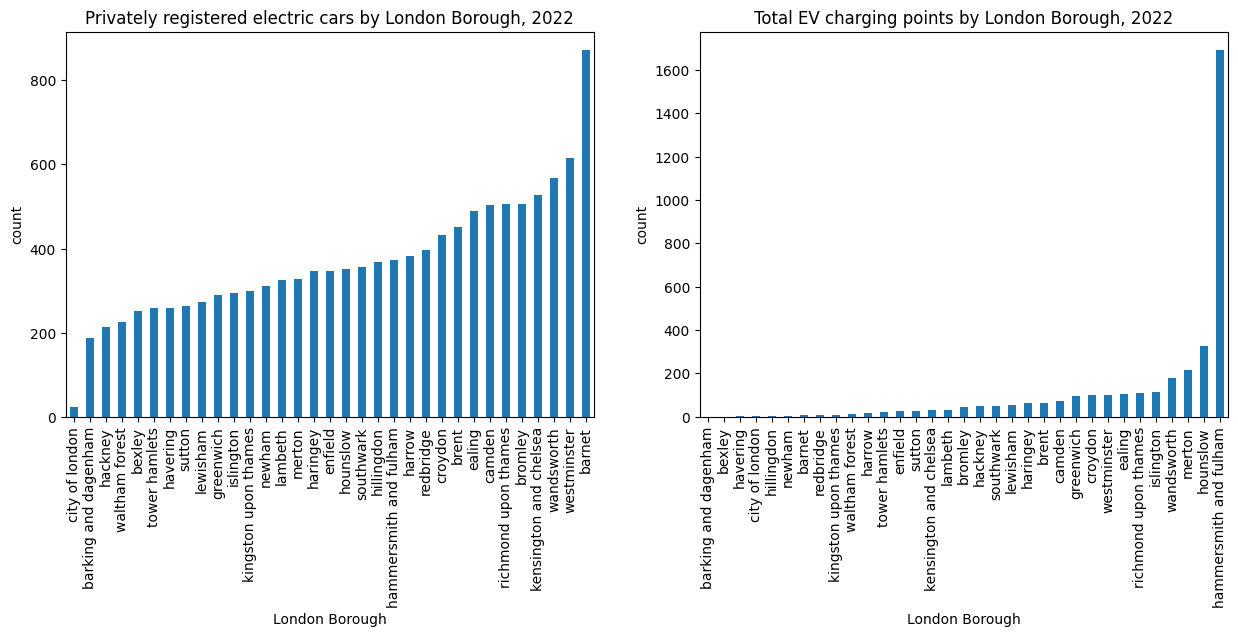

In [84]:
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
ax1 = ldn_cars_mean.sort_values().plot.bar(title='Privately registered electric cars by London Borough, 2022'
                                      , xlabel='London Borough', ylabel='count')

plt.subplot(1, 2, 2)
ax2 = borough_cps.plot.bar(title='Total EV charging points by London Borough, 2022'
                    , xlabel='London Borough', ylabel='count')
plt.show()

Interesting that the City of London has so few compared to other regions. Perhaps this is due to it being a fairly non-residential area. As of 2021 there was a population of <9000 in a 2.91km squared area (source: [Wikipedia](https://en.wikipedia.org/wiki/City_of_London)). Compare that to Barking and Dagenham, the area with the second least number of electric cars privately owned, which had a population of 218,000 in 2021 (source: [Wikipedia](https://en.wikipedia.org/wiki/London_Borough_of_Barking_and_Dagenham))